In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

In [3]:
train_set = MNIST('.MNIST', transform=T.ToTensor(), train=True, download=True)
test_set = MNIST('.MNIST', transform=T.ToTensor(), train=False, download=True)

In [3]:
len(train_set)
out = train_set[357]
out

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [4]:
image, label = out
image.shape, train_set.classes

(torch.Size([1, 28, 28]),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

In [10]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [6]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [11]:
class MLP(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=False),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )


    def forward(self, x):
        return self.model(x)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [21]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64 
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP (in_features=IMG_SIZE**2, num_classes=NUM_CLASSES, hidden_size=HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
model.model[0].weight.shape
model.model[0].bias.shape
model.model[0]


Linear(in_features=784, out_features=64, bias=True)

In [11]:
torch.flatten(images, start_dim=1).shape

torch.Size([64, 784])

In [13]:
def train():
    train_losses, training_accuracies = [], []
    test_losses, testing_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS+1):
        training_loss, training_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(torch.flatten(images, start_dim=1))     # model.forward() == model() 
            # logist: batch_size * n_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item() * images.shape[0]
            training_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        if scheduler is not None:
            scheduler.step()
        training_loss /= len(train_loader.dataset)
        training_accuracy /= len(train_loader.dataset)
        train_losses += [training_loss]
        training_accuracies += [training_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        # используется для предотвращения нормализаций
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(torch.flatten(images, start_dim=1))     # model.forward() == model() 
                # logist: batch_size * n_classes
                loss = criterion(logits, labels)
            
            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        testing_accuracies += [test_accuracy]

        plot_losses(train_losses, test_losses, training_accuracies, testing_accuracies)

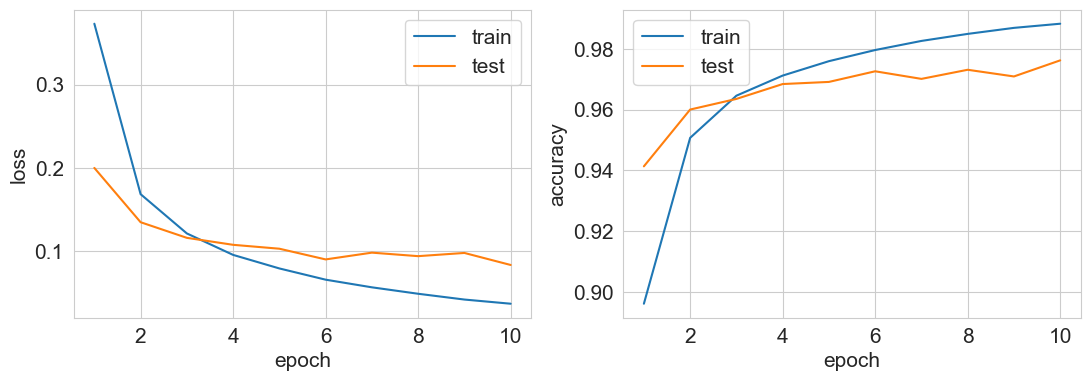

In [27]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64 
NUM_EPOCHS = 10

scheduler = None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP (in_features=IMG_SIZE**2, num_classes=NUM_CLASSES, hidden_size=HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train()

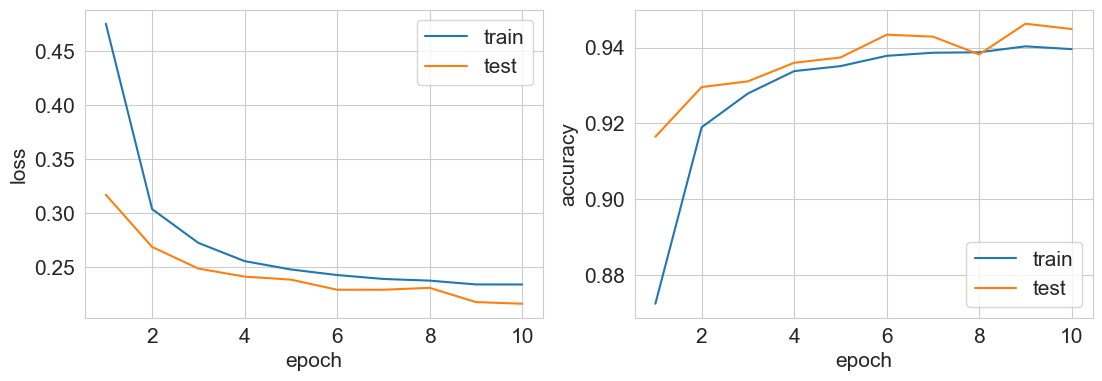

In [29]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64 
NUM_EPOCHS = 10

scheduler = None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP (in_features=IMG_SIZE**2, num_classes=NUM_CLASSES, hidden_size=HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
train()

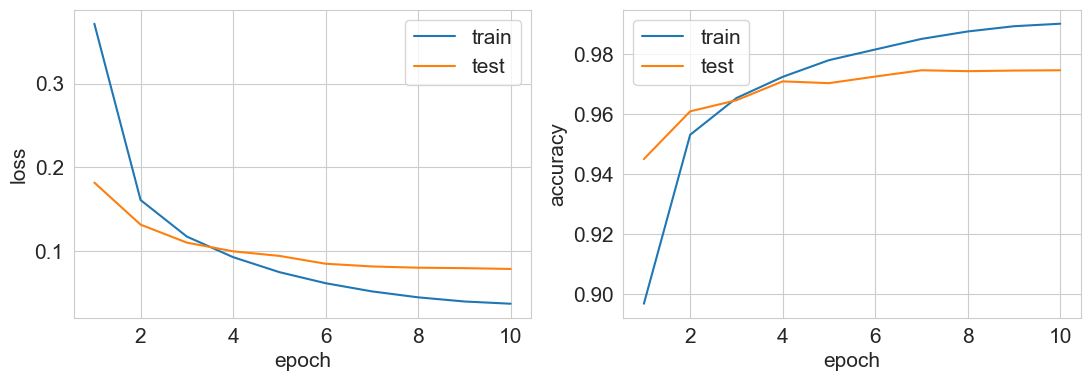

In [14]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64 
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP (in_features=IMG_SIZE**2, num_classes=NUM_CLASSES, hidden_size=HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()
train()

# Dropout

In [32]:
x = torch.ones(5, 10)
x

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [36]:
dropout = nn.Dropout(p=0.25)
dropout.train()

Dropout(p=0.25, inplace=False)

In [37]:
dropout(x)

tensor([[1.3333, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333,
         1.3333],
        [1.3333, 1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333,
         1.3333],
        [1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333,
         1.3333],
        [0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333,
         1.3333],
        [0.0000, 0.0000, 1.3333, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 1.3333,
         1.3333]])

In [38]:
dropout.eval()
dropout(x)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

# BatchNorm

In [40]:
batch_norm = nn.BatchNorm1d(num_features=10, affine=False)
batch_norm.train()

BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)

In [44]:
x = 1 + 2 * torch.randn(64, 10)
x.mean(dim=0), x.var(dim=0)

(tensor([0.9018, 1.3314, 0.7893, 0.8002, 0.9155, 0.4130, 1.1825, 0.8104, 0.7562,
         0.7925]),
 tensor([3.9474, 4.0573, 6.2616, 3.8188, 3.7215, 4.1356, 3.9947, 3.1352, 3.6656,
         4.0391]))

In [45]:
y = batch_norm(x)

In [46]:
y.mean(dim=0), y.var(dim=0)

(tensor([-7.4506e-09, -1.8626e-08,  0.0000e+00,  1.2107e-08,  9.3132e-09,
          2.2352e-08, -1.3039e-08,  1.8626e-08, -2.2352e-08, -1.4901e-08]),
 tensor([1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159, 1.0159,
         1.0159]))

In [47]:
batch_norm.running_mean

tensor([0.1182, 0.2353, 0.1090, 0.1533, 0.2960, 0.1272, 0.2706, 0.1536, 0.1049,
        0.1220])

In [48]:
batch_norm.running_var

tensor([1.3589, 1.6560, 1.6053, 2.1132, 1.3393, 1.7816, 1.9899, 1.1708, 1.6724,
        1.8555])